In [1]:
!pip install wfdb
!pip install keras-tuner --quiet
!pip install resnet1d
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


# preprocess

In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [4]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [5]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [6]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [7]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    """
    Display the ECG signal with P, QRS, and T wave masks.

    Parameters:
        signal (numpy array): The ECG signal.
        mask (numpy array): The multi-class mask (1D or 2D).
        fs (int): Sampling frequency of the ECG signal.
    """
    time = np.arange(len(signal)) / fs  # Convert sample index to time (seconds)

    # Ensure mask is 2D (L, 4) - one-hot encoded; if not, convert it
    if mask.ndim == 1:
        num_classes = 4  # Assuming classes: [Background, P, QRS, T]
        mask = np.eye(num_classes)[mask]  # Convert to one-hot (L, 4)

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    # Plot masks
    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    # Read annotations
    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    # Define window size and stride
    window_size = 240
    stride = window_size // 4  # 60 overlap

    # Padding signal before segmentation
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    #

    # Preprocessing
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    # Wave region labeling
    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)
    # 
    
    indices = np.where(mask[:, 0] != 1)[0]  # [0] extracts the indices
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    #print(last_non_zero_row)
    
    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    # Segment the signal and mask
    #print(signal,mask)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)
    

    # Ensure last segment ends at the last signal index
    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  # Assuming padding mask as background


    # Adjust final shape
    segments = np.expand_dims(segments, axis=1) # (N, 1, L)
    
    
    masks = np.argmax(masks, axis=-1)            # (N, L)
    #print("done")
    

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:17<00:00,  5.97it/s]


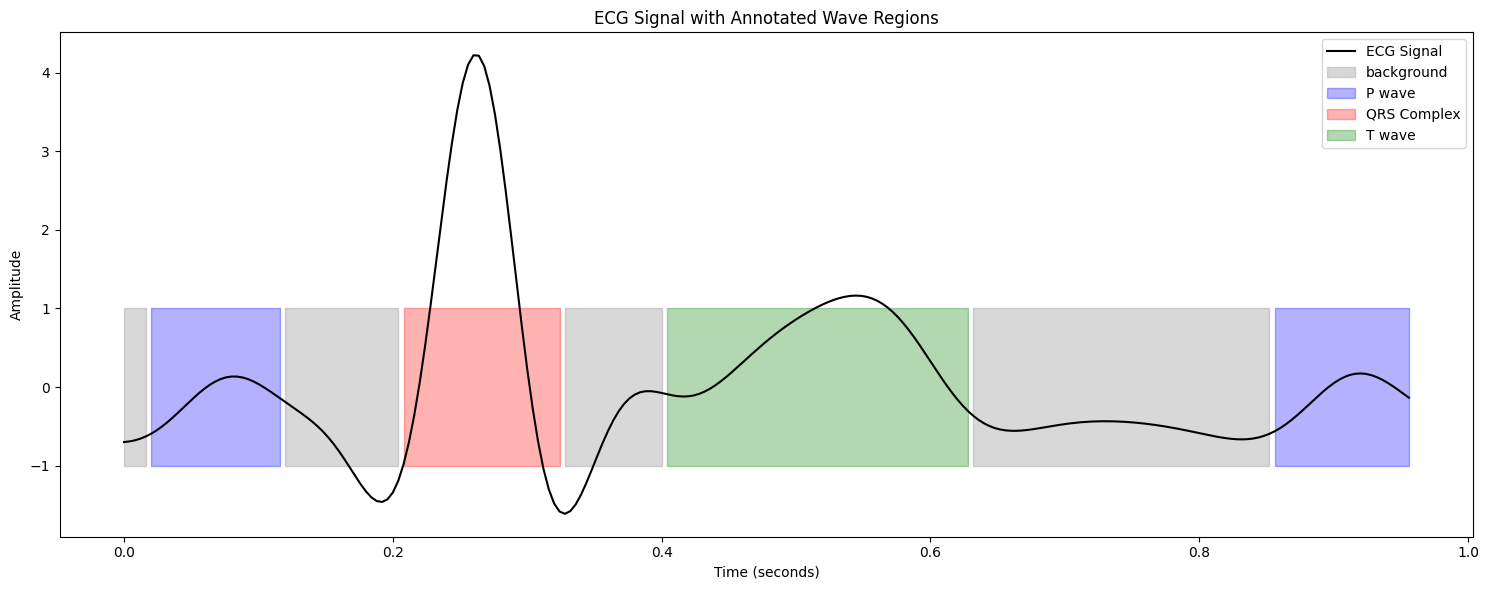

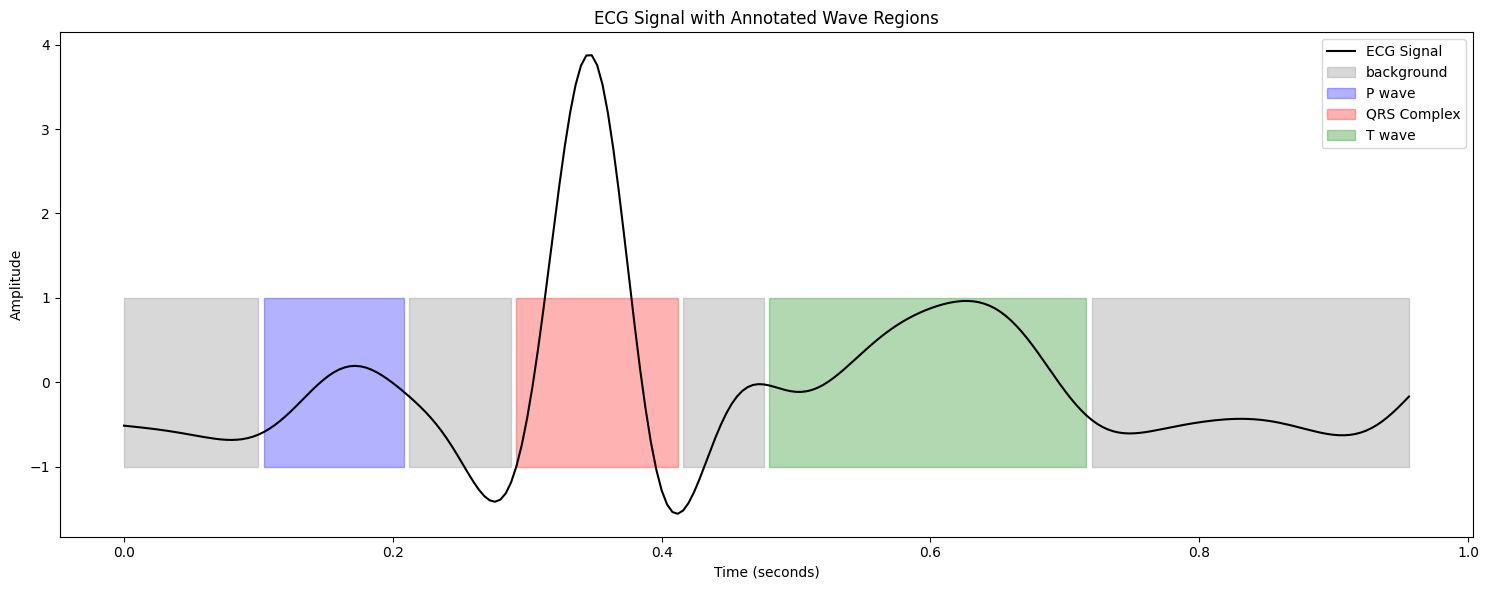

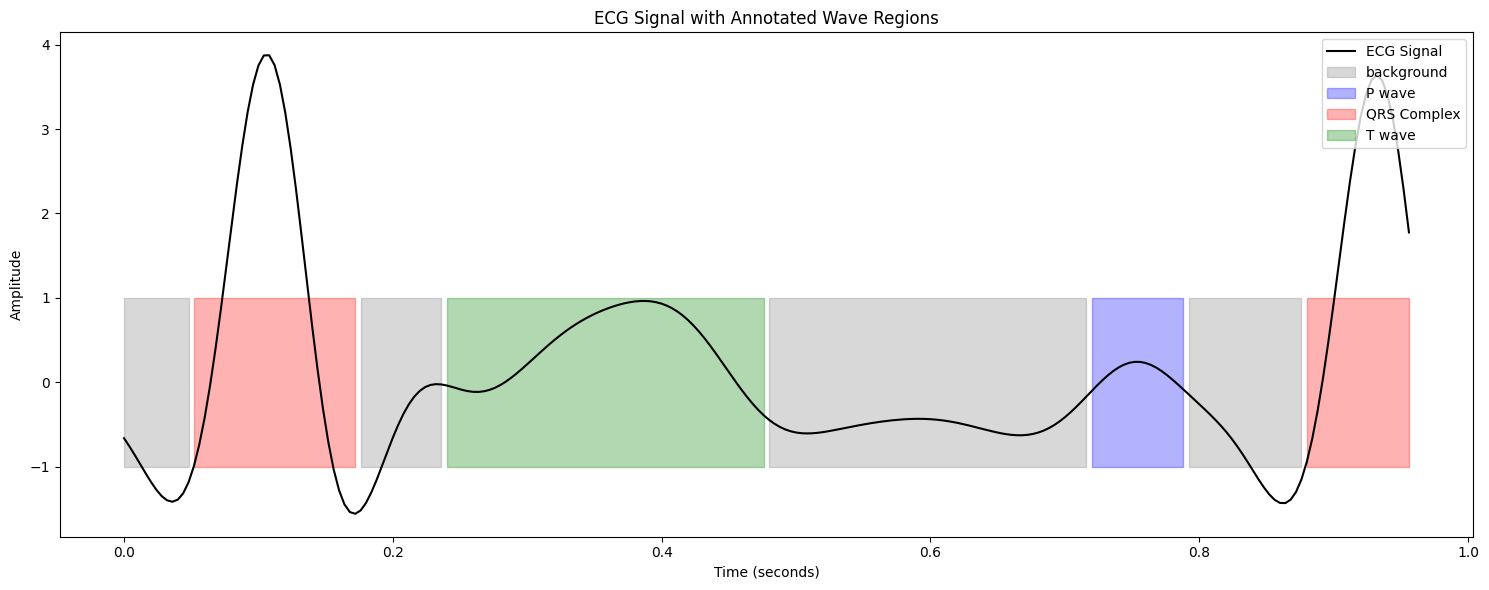

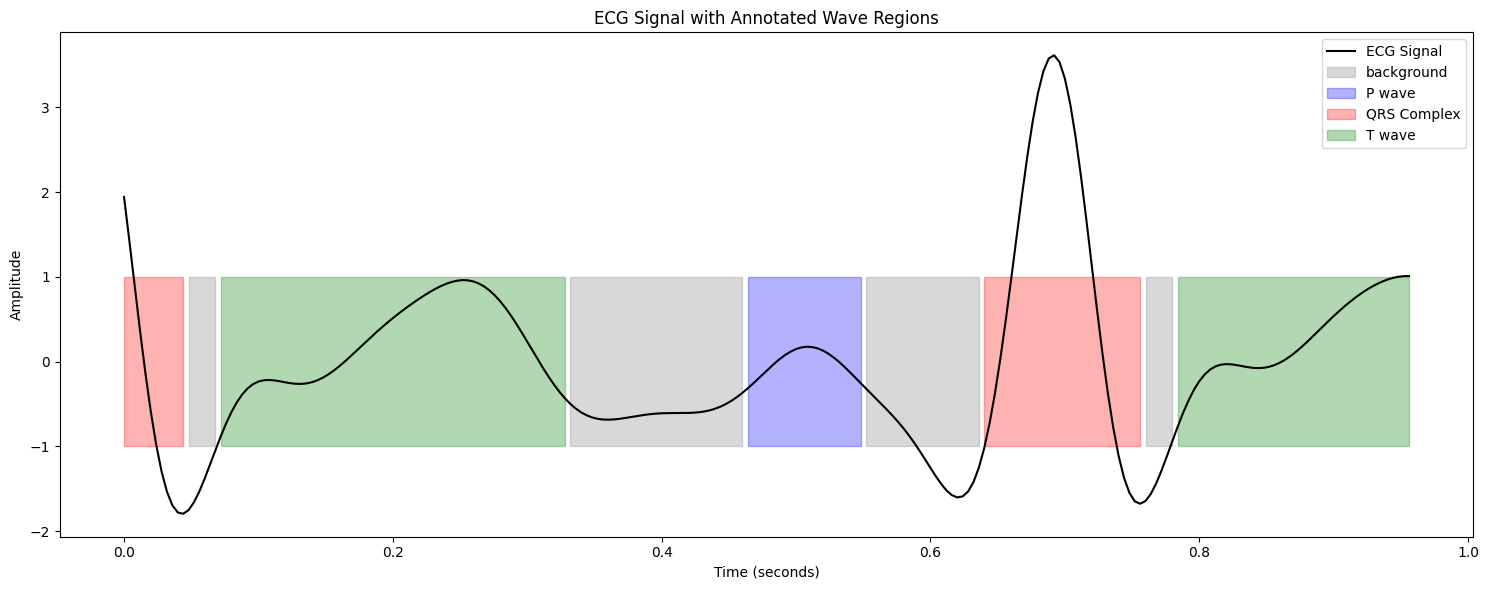

In [11]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"    
    try:
        
        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
        
    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])
        


Processing LUDB Records: 100%|██████████| 200/200 [00:03<00:00, 52.41it/s]


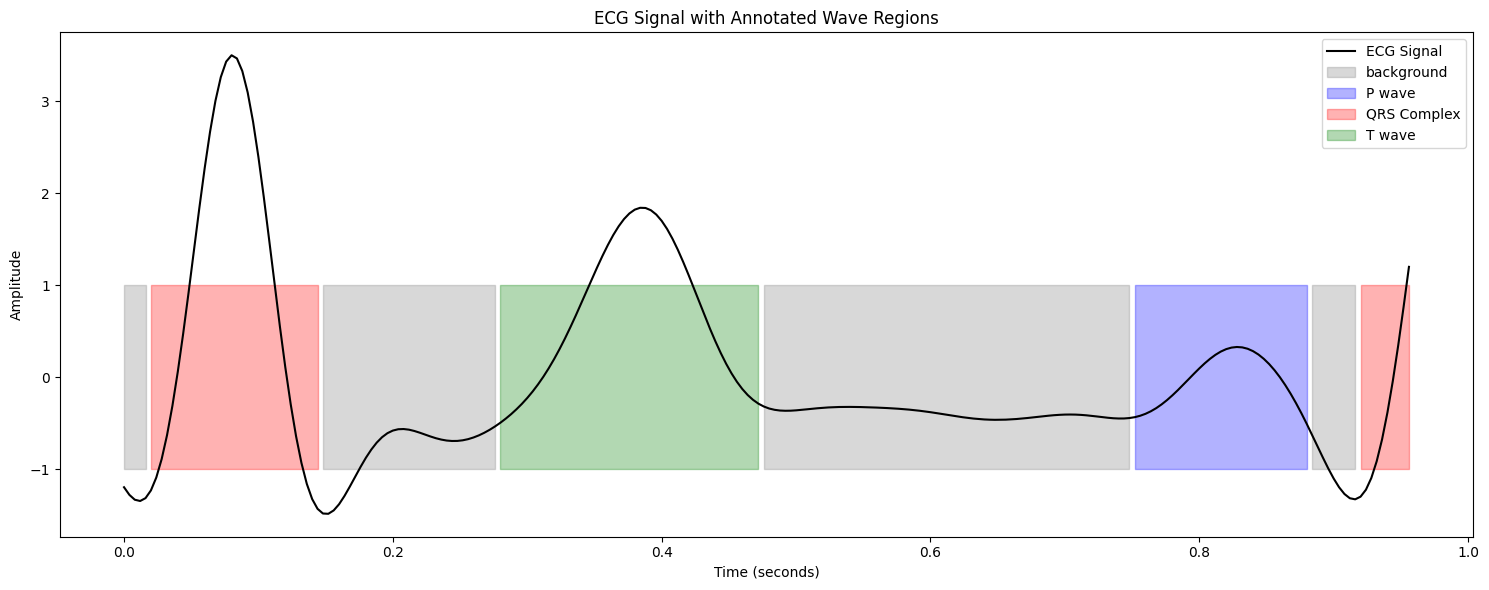

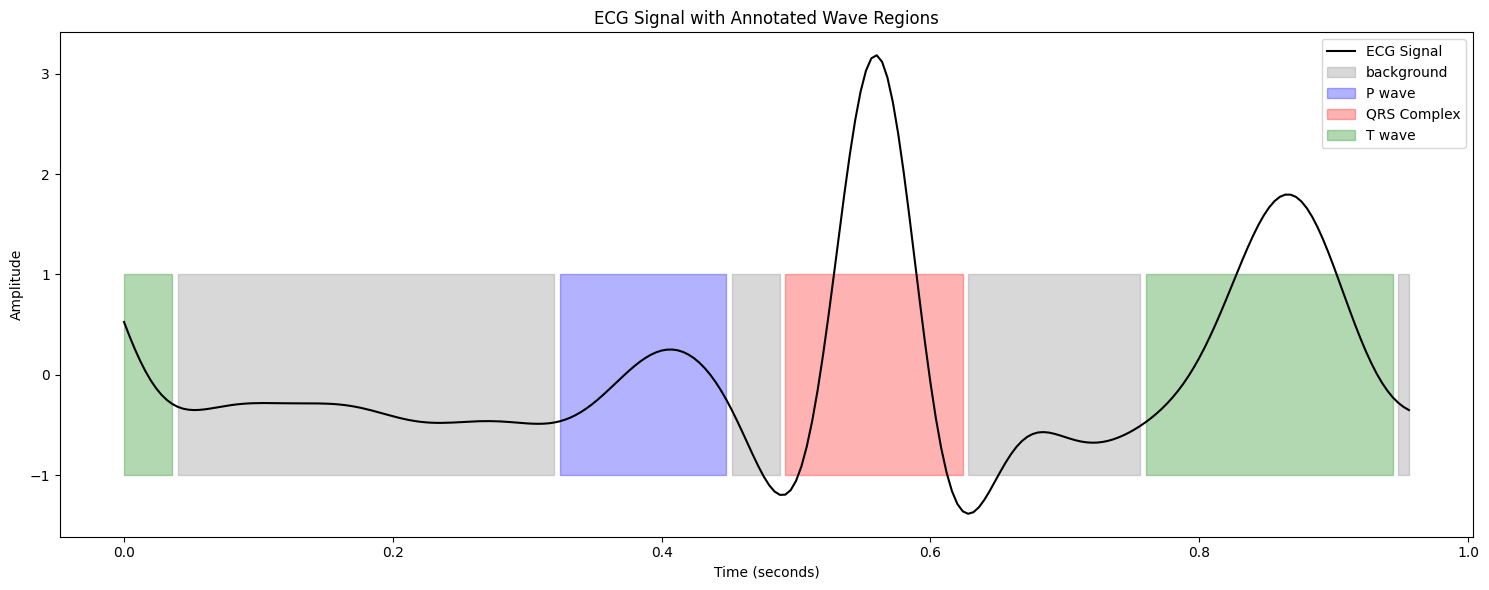

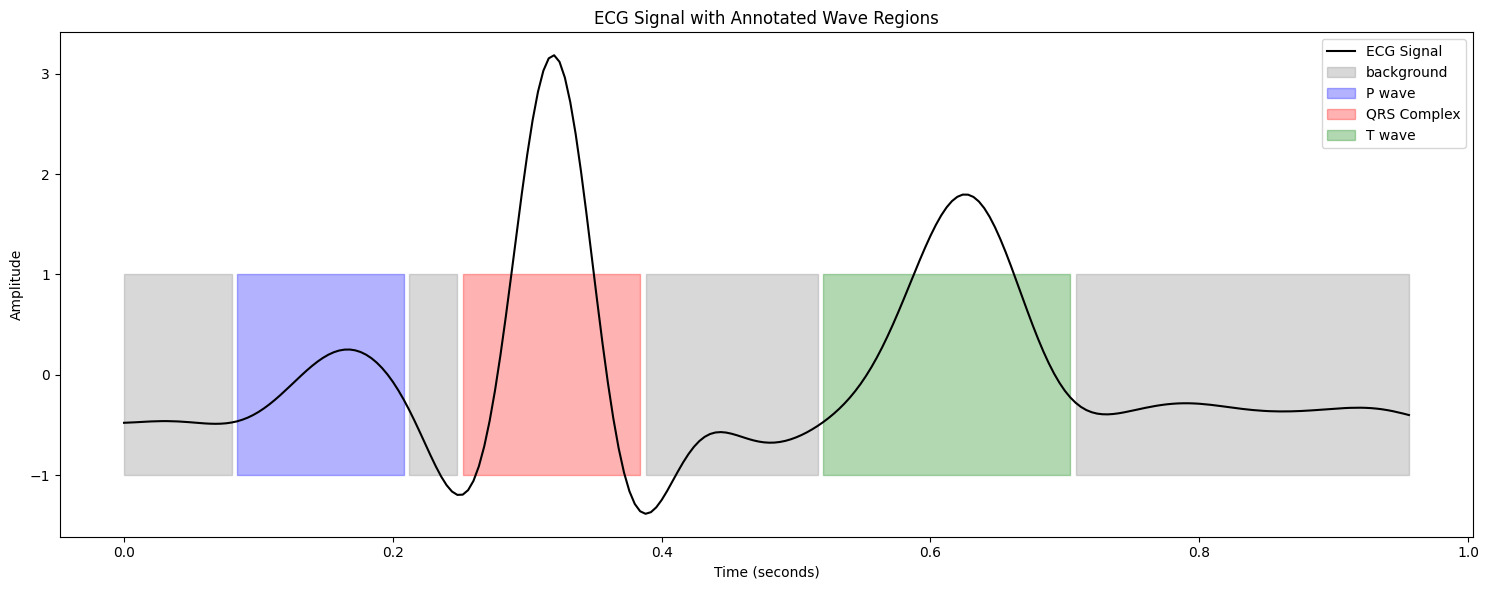

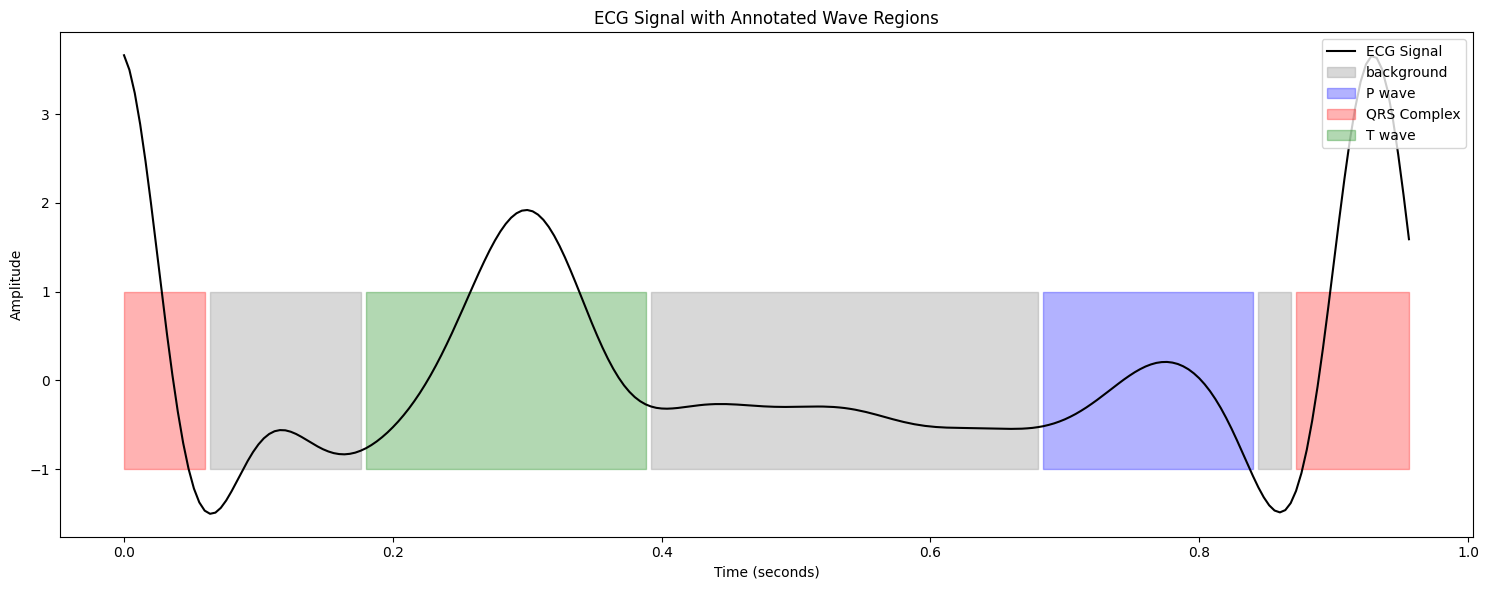

In [12]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:
        
        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
        
    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")



        
display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [15]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [2 2 2 ... 2 2 2]]


In [16]:
import numpy as np

# Flatten y to 1D
flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)

# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {0: 45861096, 1: 9742522, 2: 17298084, 3: 22661258}
Class Weights (Relative Frequency): {0: 0.47990451530593026, 1: 0.10194872574060075, 2: 0.1810124341062688, 3: 0.2371343248472002}
Weight of Class 0: 0.4799


In [17]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

# split dataset

In [18]:
# Create train/test sets (e.g., 80/20 split)
from sklearn.model_selection import train_test_split

# First split 80% train, 20% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split 50/50 on temp → 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [19]:
from torch.utils.data import Dataset, DataLoader

class ECGWaveformDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.long)

train_dataset = ECGWaveformDataset(X_train, y_train)
val_dataset = ECGWaveformDataset(X_val, y_val)
test_dataset = ECGWaveformDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [20]:
X=None
y=None

# model and training

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock1D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super(UNet1D, self).__init__()
        self.enc1 = ConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ConvBlock1D(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ConvBlock1D(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ConvBlock1D(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool1d(2)

        self.bottleneck = ConvBlock1D(base_filters * 8, base_filters * 16)

        self.upconv4 = nn.ConvTranspose1d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock1D(base_filters * 16, base_filters * 8)

        self.upconv3 = nn.ConvTranspose1d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock1D(base_filters * 8, base_filters * 4)

        self.upconv2 = nn.ConvTranspose1d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock1D(base_filters * 4, base_filters * 2)

        self.upconv1 = nn.ConvTranspose1d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ConvBlock1D(base_filters * 2, base_filters)

        self.final_conv = nn.Conv1d(base_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with cropping
        d4 = self.upconv4(b)
        e4 = center_crop(e4, d4.shape[-1])
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = center_crop(e3, d3.shape[-1])
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = center_crop(e2, d2.shape[-1])
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = center_crop(e1, d1.shape[-1])
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final_conv(d1)  # Output shape: (B, n_classes, L)


In [22]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet1D(n_classes=4)  # background, P, QRS, T
x = torch.randn(8, 1, 256)   # batch of ECG segments
out = model(x)
print(out.shape)  # → (8, 4, 256)

class_weights = torch.tensor([0.2, 0.4, 0.3, 0.1], dtype=torch.float32).to(device)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


torch.Size([8, 4, 256])


In [23]:
from tqdm import tqdm

# Compute pixel-wise (point-wise) accuracy
def compute_accuracy(outputs, targets):
    # outputs: (B, C, L), targets: (B, L)0.atr
    preds = torch.argmax(outputs, dim=1)  # (B, L)
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_bar = tqdm(train_loader, desc=f"🧪 Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for X_batch, y_batch in train_bar:
            X_batch = X_batch.to(device)  # (B, 1, L) — good!
            y_batch = y_batch.to(device)  # (B, L)

            optimizer.zero_grad()
            output = model(X_batch)  # (B, C, L)
            loss = criterion(output, y_batch)
            acc = compute_accuracy(output, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            train_bar.set_postfix(loss=loss.item(), acc=f"{acc*100:.2f}%")

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"📘 Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc/len(train_loader)*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="🔍 Validating", leave=False)
        for X_batch, y_batch in val_bar:
            X_batch = X_batch.to(device)  # (B, 1, L) — good!
            y_batch = y_batch.to(device)  # (B, L)


            output = model(X_batch)
            loss = criterion(output, y_batch)
            acc = compute_accuracy(output, y_batch)

            total_loss += loss.item()
            total_acc += acc

            val_bar.set_postfix(val_loss=loss.item(), acc=f"{acc*100:.2f}%")

    return total_loss / len(val_loader), total_acc / len(val_loader)


In [24]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=50)

📘 Epoch 1/50 | Train Loss: 0.2167 | Train Acc: 90.37% | Val Loss: 0.1826 | Val Acc: 91.39%


📘 Epoch 2/50 | Train Loss: 0.1685 | Train Acc: 92.39% | Val Loss: 0.1573 | Val Acc: 92.90%


📘 Epoch 3/50 | Train Loss: 0.1537 | Train Acc: 92.99% | Val Loss: 0.1492 | Val Acc: 93.17%


📘 Epoch 4/50 | Train Loss: 0.1440 | Train Acc: 93.39% | Val Loss: 0.1410 | Val Acc: 93.55%


📘 Epoch 5/50 | Train Loss: 0.1369 | Train Acc: 93.66% | Val Loss: 0.1381 | Val Acc: 93.26%


📘 Epoch 6/50 | Train Loss: 0.1308 | Train Acc: 93.91% | Val Loss: 0.1383 | Val Acc: 93.57%


📘 Epoch 7/50 | Train Loss: 0.1255 | Train Acc: 94.15% | Val Loss: 0.1333 | Val Acc: 93.87%


📘 Epoch 8/50 | Train Loss: 0.1204 | Train Acc: 94.37% | Val Loss: 0.1277 | Val Acc: 94.14%


📘 Epoch 9/50 | Train Loss: 0.1159 | Train Acc: 94.56% | Val Loss: 0.1276 | Val Acc: 94.00%


📘 Epoch 10/50 | Train Loss: 0.1113 | Train Acc: 94.76% | Val Loss: 0.1266 | Val Acc: 94.39%


📘 Epoch 11/50 | Train Loss: 0.1071 | Train Acc: 94.95% | Val Loss: 0.1227 | Val Acc: 94.59%


📘 Epoch 12/50 | Train Loss: 0.1029 | Train Acc: 95.15% | Val Loss: 0.1251 | Val Acc: 94.25%


📘 Epoch 13/50 | Train Loss: 0.0994 | Train Acc: 95.31% | Val Loss: 0.1272 | Val Acc: 94.42%


📘 Epoch 14/50 | Train Loss: 0.0957 | Train Acc: 95.49% | Val Loss: 0.1237 | Val Acc: 94.50%


📘 Epoch 15/50 | Train Loss: 0.0924 | Train Acc: 95.65% | Val Loss: 0.1270 | Val Acc: 94.48%


📘 Epoch 16/50 | Train Loss: 0.0892 | Train Acc: 95.81% | Val Loss: 0.1258 | Val Acc: 94.64%


📘 Epoch 17/50 | Train Loss: 0.0865 | Train Acc: 95.94% | Val Loss: 0.1296 | Val Acc: 94.58%


📘 Epoch 18/50 | Train Loss: 0.0837 | Train Acc: 96.08% | Val Loss: 0.1266 | Val Acc: 94.69%


📘 Epoch 19/50 | Train Loss: 0.0812 | Train Acc: 96.20% | Val Loss: 0.1291 | Val Acc: 94.94%


📘 Epoch 20/50 | Train Loss: 0.0789 | Train Acc: 96.32% | Val Loss: 0.1290 | Val Acc: 94.89%


📘 Epoch 21/50 | Train Loss: 0.0767 | Train Acc: 96.43% | Val Loss: 0.1318 | Val Acc: 94.95%


📘 Epoch 22/50 | Train Loss: 0.0746 | Train Acc: 96.52% | Val Loss: 0.1317 | Val Acc: 94.92%


📘 Epoch 23/50 | Train Loss: 0.0726 | Train Acc: 96.62% | Val Loss: 0.1339 | Val Acc: 94.95%


📘 Epoch 24/50 | Train Loss: 0.0710 | Train Acc: 96.70% | Val Loss: 0.1378 | Val Acc: 94.90%


📘 Epoch 25/50 | Train Loss: 0.0692 | Train Acc: 96.79% | Val Loss: 0.1362 | Val Acc: 94.98%


📘 Epoch 26/50 | Train Loss: 0.0676 | Train Acc: 96.87% | Val Loss: 0.1411 | Val Acc: 94.97%


📘 Epoch 27/50 | Train Loss: 0.0660 | Train Acc: 96.94% | Val Loss: 0.1381 | Val Acc: 95.01%


📘 Epoch 28/50 | Train Loss: 0.0645 | Train Acc: 97.00% | Val Loss: 0.1444 | Val Acc: 95.06%


📘 Epoch 29/50 | Train Loss: 0.0631 | Train Acc: 97.08% | Val Loss: 0.1403 | Val Acc: 95.15%


📘 Epoch 30/50 | Train Loss: 0.0618 | Train Acc: 97.14% | Val Loss: 0.1473 | Val Acc: 94.99%


📘 Epoch 31/50 | Train Loss: 0.0606 | Train Acc: 97.20% | Val Loss: 0.1476 | Val Acc: 95.00%


📘 Epoch 32/50 | Train Loss: 0.0593 | Train Acc: 97.26% | Val Loss: 0.1475 | Val Acc: 95.07%


📘 Epoch 33/50 | Train Loss: 0.0582 | Train Acc: 97.31% | Val Loss: 0.1486 | Val Acc: 95.00%


📘 Epoch 34/50 | Train Loss: 0.0572 | Train Acc: 97.36% | Val Loss: 0.1485 | Val Acc: 95.19%


📘 Epoch 35/50 | Train Loss: 0.0563 | Train Acc: 97.41% | Val Loss: 0.1513 | Val Acc: 95.19%


📘 Epoch 36/50 | Train Loss: 0.0552 | Train Acc: 97.45% | Val Loss: 0.1498 | Val Acc: 94.99%


📘 Epoch 37/50 | Train Loss: 0.0541 | Train Acc: 97.50% | Val Loss: 0.1589 | Val Acc: 95.02%


📘 Epoch 38/50 | Train Loss: 0.0533 | Train Acc: 97.55% | Val Loss: 0.1557 | Val Acc: 95.15%


📘 Epoch 39/50 | Train Loss: 0.0525 | Train Acc: 97.58% | Val Loss: 0.1633 | Val Acc: 94.91%


📘 Epoch 40/50 | Train Loss: 0.0517 | Train Acc: 97.62% | Val Loss: 0.1559 | Val Acc: 95.24%


📘 Epoch 41/50 | Train Loss: 0.0507 | Train Acc: 97.66% | Val Loss: 0.1571 | Val Acc: 95.21%


📘 Epoch 42/50 | Train Loss: 0.0502 | Train Acc: 97.69% | Val Loss: 0.1543 | Val Acc: 95.10%


📘 Epoch 43/50 | Train Loss: 0.0494 | Train Acc: 97.74% | Val Loss: 0.1569 | Val Acc: 95.25%


📘 Epoch 44/50 | Train Loss: 0.0486 | Train Acc: 97.76% | Val Loss: 0.1643 | Val Acc: 95.26%


📘 Epoch 45/50 | Train Loss: 0.0478 | Train Acc: 97.80% | Val Loss: 0.1605 | Val Acc: 95.17%


📘 Epoch 46/50 | Train Loss: 0.0471 | Train Acc: 97.84% | Val Loss: 0.1609 | Val Acc: 95.22%


📘 Epoch 47/50 | Train Loss: 0.0464 | Train Acc: 97.87% | Val Loss: 0.1674 | Val Acc: 95.29%


📘 Epoch 48/50 | Train Loss: 0.0458 | Train Acc: 97.90% | Val Loss: 0.1653 | Val Acc: 95.24%


📘 Epoch 49/50 | Train Loss: 0.0452 | Train Acc: 97.92% | Val Loss: 0.1608 | Val Acc: 95.35%


📘 Epoch 50/50 | Train Loss: 0.0447 | Train Acc: 97.95% | Val Loss: 0.1757 | Val Acc: 95.30%


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader):
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)  # shape: (1, 1, L)

            # Handle label shape
            if y_batch.dim() == 3 and y_batch.shape[-1] > 1:
                y_batch = y_batch.argmax(dim=2)
            y_batch = y_batch.to(device)  # shape: (1, L)

            output = model(X_batch)       # shape: (1, C, L)
            preds = torch.argmax(output, dim=1)  # shape: (1, L)

            acc = (preds == y_batch).float().mean()
            test_acc += acc.item()

            # === Visualization ===
            if i == 0:  # plot first sample
                signal = X_batch[0, 0].cpu().numpy()
                pred_mask = preds[0].cpu().numpy()
                true_mask = y_batch[0].cpu().numpy()
                time = np.arange(len(signal))

                plt.figure(figsize=(15, 6))
                plt.plot(time, signal, color='black', label='ECG Signal')

                # Plot predictions
                for class_idx, color, label in zip([1, 2, 3], ['blue', 'red', 'green'], ['P', 'QRS', 'T']):
                    plt.fill_between(time, -1, 1, where=pred_mask == class_idx, color=color, alpha=0.3, label=f'Predicted {label}')
                    plt.fill_between(time, -1, 1, where=true_mask == class_idx, color=color, alpha=0.1, label=f'True {label}', linestyle='dashed')

                plt.title('Predicted vs Ground Truth Mask on Test Sample')
                plt.xlabel('Time (samples)')
                plt.ylabel('Amplitude')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()

    avg_acc = test_acc / len(test_loader)
    print(f"✅ Test Accuracy: {avg_acc * 100:.2f}%")

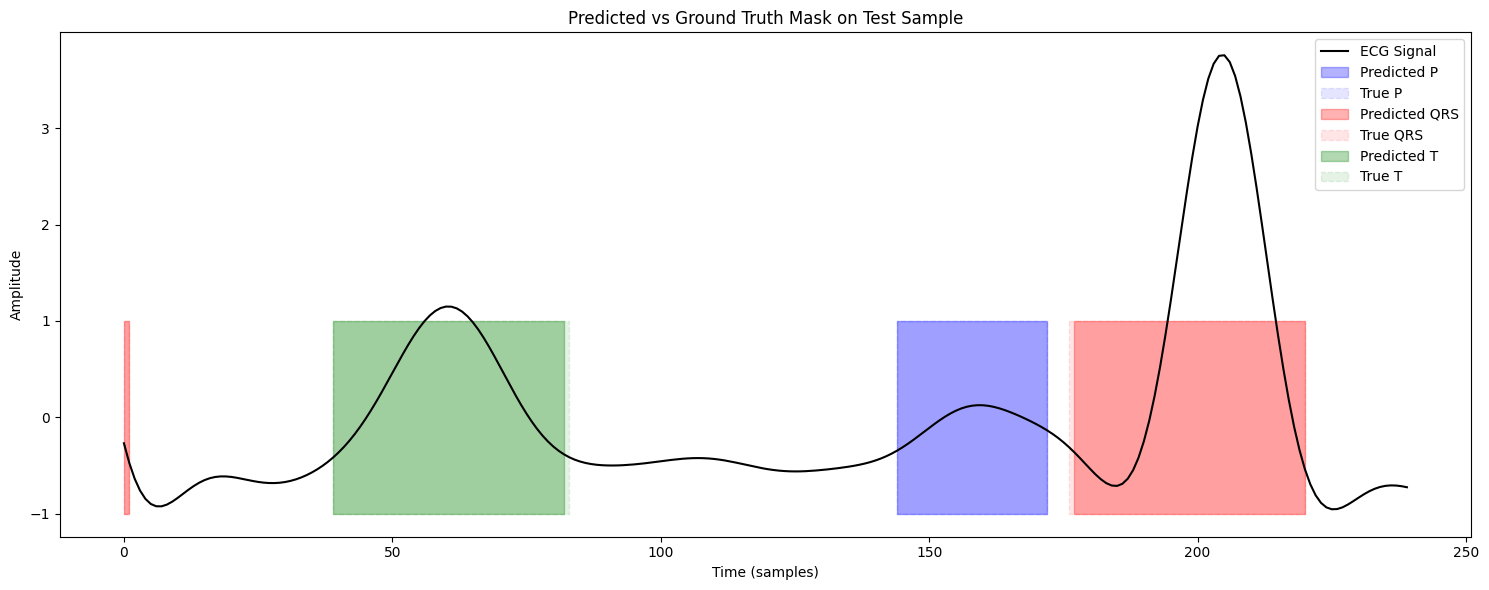

✅ Test Accuracy: 95.24%


In [26]:
test(model, test_loader)


In [27]:
torch.save(model.state_dict(), "unet1d_ecg_qrs.pth")


# testing model on ecg signal

In [28]:
model = UNet1D(n_classes=4)
model.load_state_dict(torch.load("/kaggle/working/unet1d_ecg_qrs.pth", map_location=device))
model.to(device)
model.eval()


<ipython-input-28-11bedb0bf6c4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/unet1d_ecg_qrs.pth", map_location=device))

UNet1D(
  (enc1): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool

In [29]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    predictions = []
    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction


In [30]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


{'P': [(294, 325), (465, 479), (576, 577), (593, 615), (855, 859), (861, 893), (1160, 1163), (1165, 1165), (1424, 1439), (1447, 1461), (1749, 1761), (1907, 1919), (1979, 2013), (2143, 2159), (2330, 2357), (2615, 2665), (2929, 2950), (3196, 3234), (3490, 3511), (3801, 3814), (4078, 4079), (4107, 4124), (4703, 4719), (5000, 5005), (5255, 5298), (5576, 5589), (5865, 5873), (6156, 6160), (6162, 6162), (6462, 6474), (6481, 6499), (6775, 6790), (6792, 6792), (7015, 7053), (7338, 7340), (7860, 7901), (8172, 8195), (8763, 8786)], 'QRS': [(44, 83), (345, 376), (630, 666), (919, 950), (1201, 1237), (1487, 1515), (1783, 1817), (2017, 2051), (2372, 2410), (2679, 2713), (2969, 3004), (3253, 3288), (3529, 3563), (3836, 3866), (4143, 4177), (4436, 4472), (4733, 4764), (5031, 5067), (5314, 5350), (5608, 5638), (5893, 5922), (6187, 6214), (6477, 6479), (6500, 6531), (6797, 6830), (7078, 7113), (7365, 7394), (7640, 7670), (7922, 7958), (8219, 8246), (8511, 8545), (8816, 8843), (8874, 8877)], 'T': [(152,

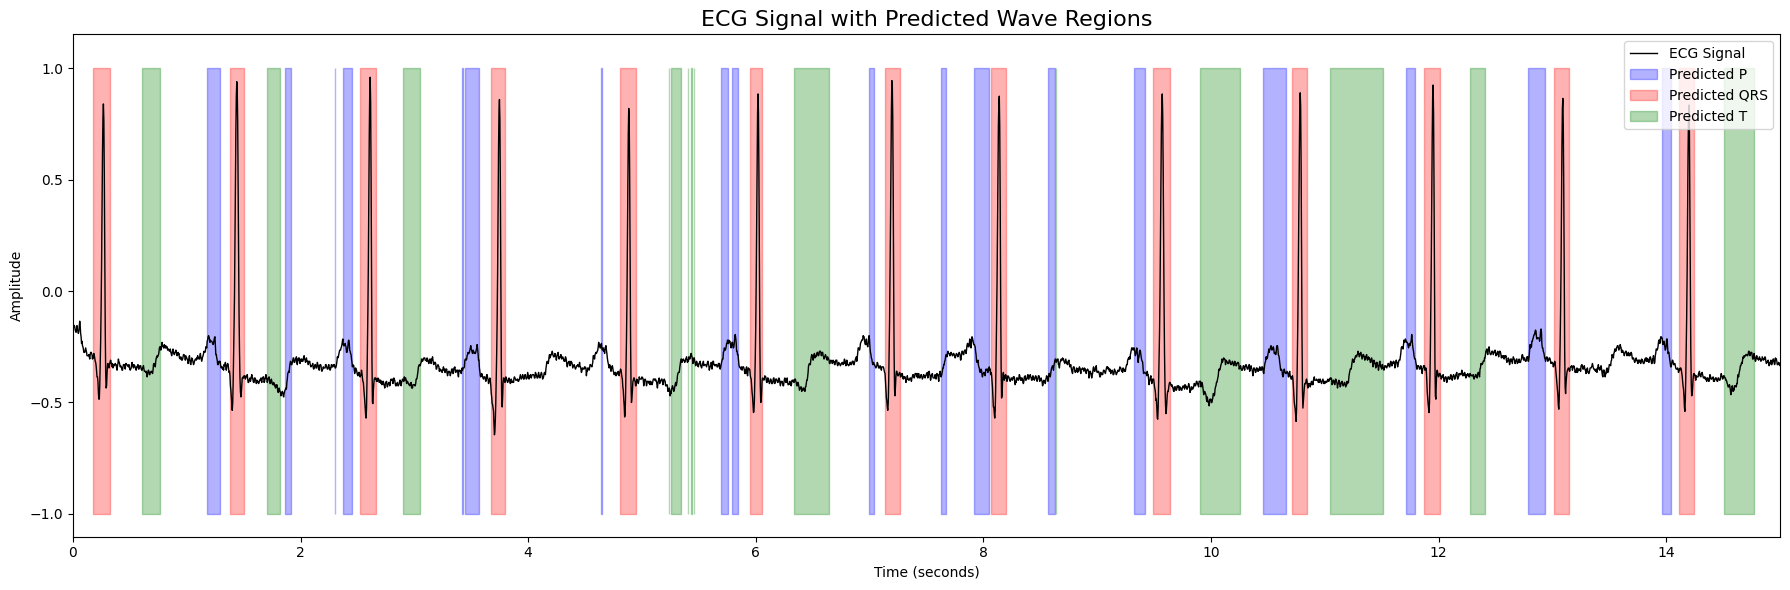

In [32]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord('/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/100')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(218, 220), (222, 223), (226, 239), (489, 516), (1040, 1063), (1304, 1327), (1575, 1597), (1841, 1865), (2116, 2148), (2382, 2405), (2640, 2674), (2911, 2945), (3178, 3215), (3717, 3717), (3729, 3754), (4265, 4302), (4558, 4571), (4805, 4843), (5354, 5396), (5640, 5645), (5648, 5652), (5662, 5662), (5893, 5933), (6185, 6212), (6480, 6490), (6998, 7000), (7032, 7039), (7280, 7320), (7569, 7593), (8103, 8140), (8400, 8415), (8662, 8697)], 'QRS': [(0, 0), (8, 19), (250, 285), (525, 565), (800, 842), (1071, 1108), (1335, 1375), (1604, 1643), (1873, 1913), (2149, 2182), (2414, 2452), (2684, 2725), (2954, 2991), (3223, 3260), (3493, 3533), (3762, 3800), (4031, 4071), (4310, 4347), (4580, 4618), (4851, 4894), (5128, 5168), (5400, 5438), (5440, 5441), (5670, 5710), (5941, 5981), (6215, 6256), (6499, 6537), (6768, 6810), (7049, 7089), (7324, 7364), (7601, 7636), (7873, 7913), (8150, 8185), (8423, 8462), (8705, 8741), (8863, 8879)], 'T': [(57, 111), (330, 379), (606, 660), (884, 935), (11

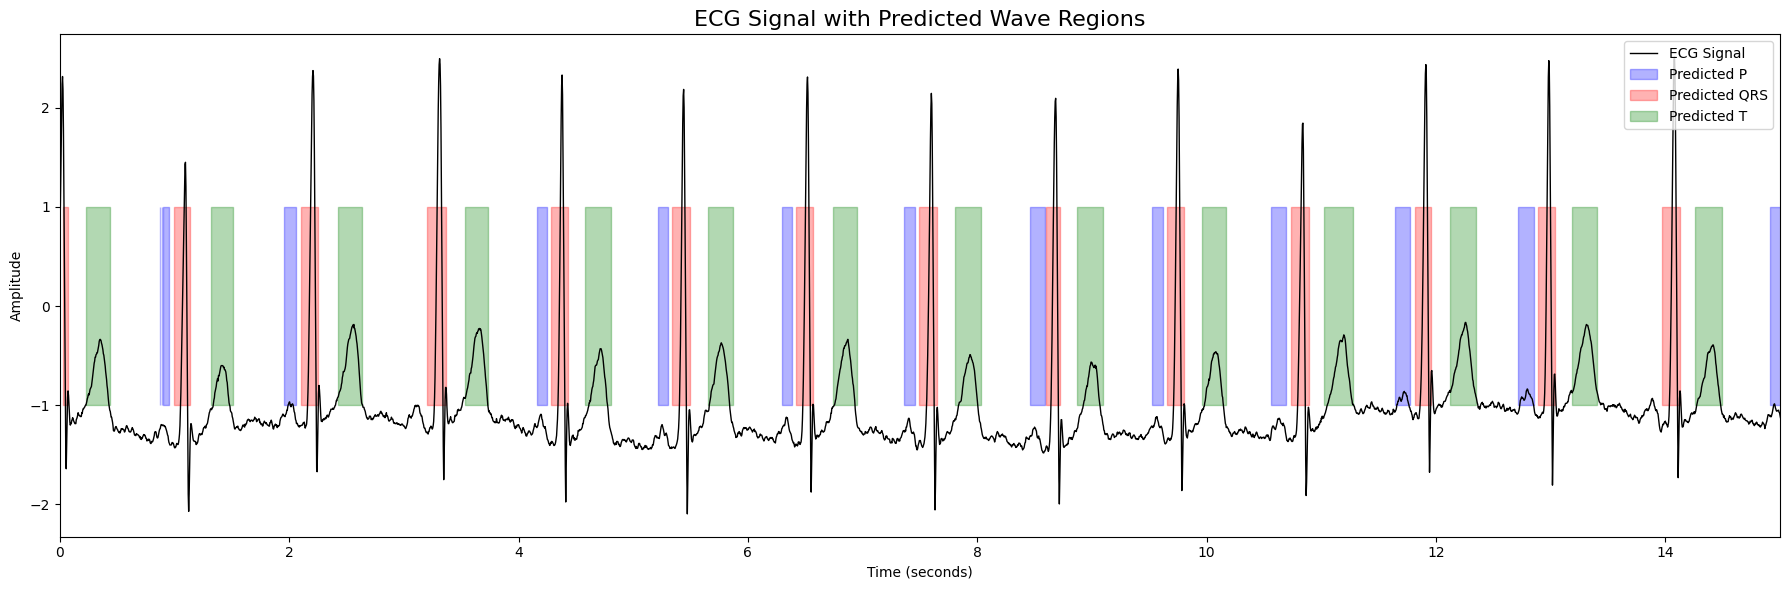

In [33]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord('/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(154, 188), (393, 426), (633, 666), (873, 900), (1110, 1146), (1354, 1390), (1593, 1628), (1830, 1860), (2066, 2101), (2314, 2345), (2347, 2349), (2565, 2593), (2806, 2820), (3037, 3070), (3276, 3311), (3515, 3550), (3765, 3798), (4008, 4031), (4247, 4281), (4485, 4518), (4727, 4752), (4758, 4762), (4980, 4981), (4984, 5016), (5232, 5258), (5470, 5500), (5709, 5738), (5952, 5983), (6190, 6224), (6433, 6457), (6463, 6468), (6684, 6710), (6924, 6951), (7152, 7187), (7393, 7417), (7634, 7668), (7873, 7906), (8103, 8127), (8138, 8138), (8351, 8365), (8373, 8376), (8581, 8615)], 'QRS': [(204, 235), (440, 470), (681, 711), (917, 948), (1162, 1192), (1405, 1435), (1645, 1675), (1877, 1907), (2118, 2150), (2368, 2397), (2610, 2639), (2848, 2877), (2880, 2884), (3087, 3116), (3120, 3123), (3329, 3357), (3360, 3363), (3569, 3597), (3814, 3842), (4058, 4086), (4297, 4331), (4535, 4568), (4780, 4810), (5032, 5060), (5277, 5304), (5517, 5545), (5756, 5785), (5999, 6025), (6236, 6239), (6241,

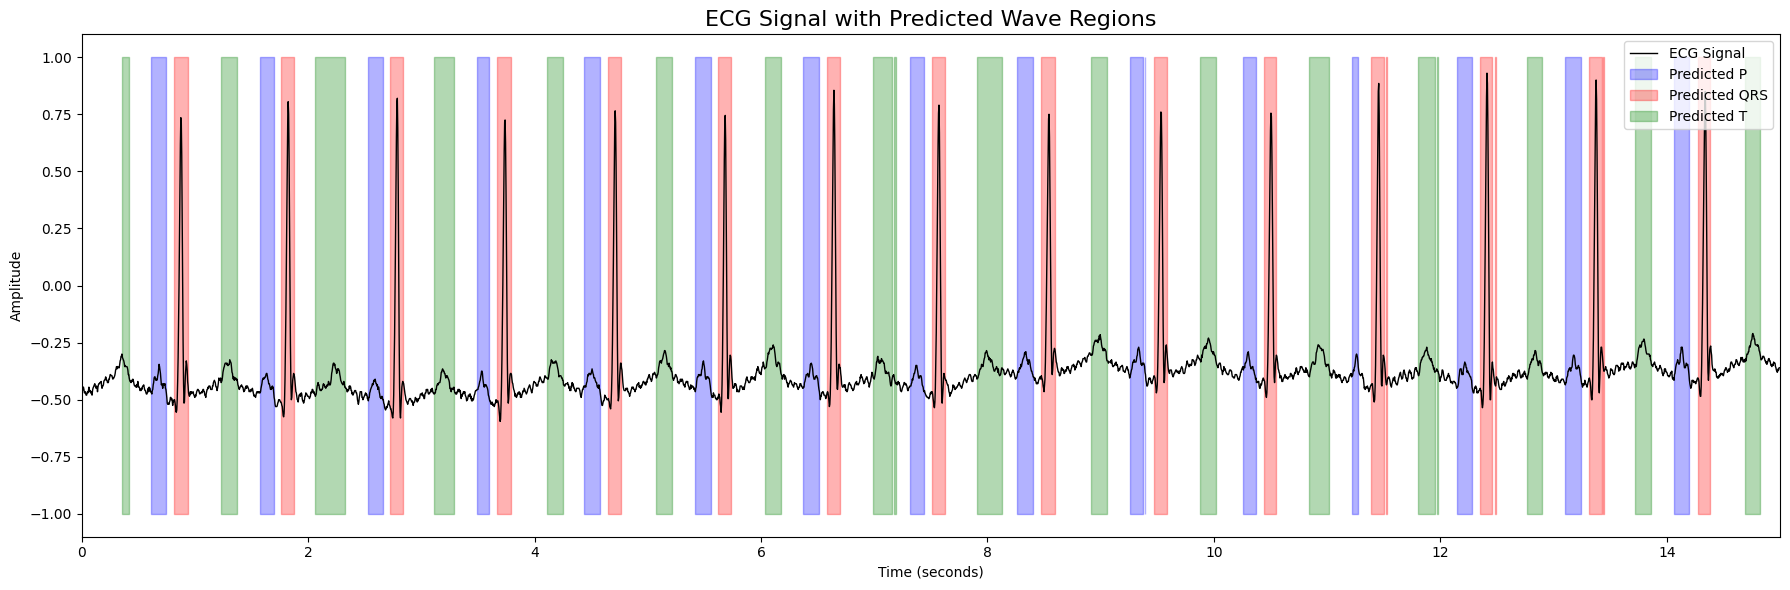

In [34]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord('/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

{'P': [(247, 279), (670, 705), (889, 920), (1018, 1049), (1305, 1340), (1747, 1777), (1956, 1991), (2096, 2115), (2376, 2407), (2599, 2629), (2805, 2838), (2941, 2953), (3234, 3267), (3447, 3477), (3656, 3686), (3870, 3898), (4084, 4116), (4320, 4331), (4427, 4457), (4716, 4751), (5146, 5175), (5368, 5397), (5972, 6003), (6174, 6211), (6391, 6422), (6607, 6638), (6813, 6847), (7026, 7057), (7233, 7269), (7632, 7667), (7845, 7845), (7855, 7882), (7973, 7973), (7980, 8007), (8273, 8306), (8479, 8514), (8687, 8721), (8860, 8861), (8867, 8876)], 'QRS': [(13, 59), (282, 329), (448, 516), (715, 759), (927, 969), (1060, 1133), (1347, 1393), (1508, 1581), (1781, 1829), (2001, 2045), (2129, 2200), (2416, 2454), (2638, 2676), (2678, 2678), (2849, 2890), (2980, 3053), (3271, 3316), (3485, 3529), (3694, 3735), (3907, 3953), (4123, 4170), (4339, 4383), (4476, 4549), (4759, 4806), (4910, 4972), (5183, 5227), (5403, 5447), (5544, 5590), (5718, 5783), (5790, 5791), (6009, 6053), (6218, 6262), (6429, 6

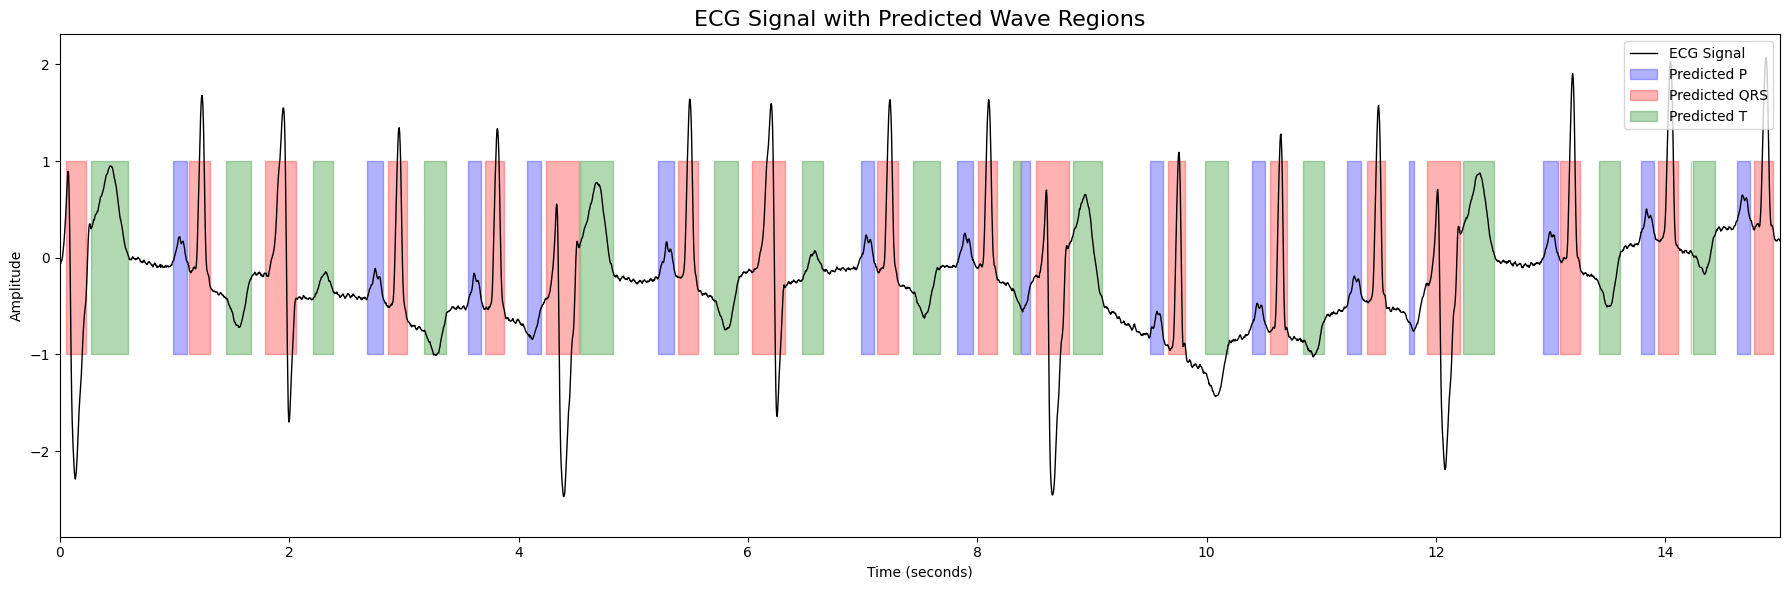

In [35]:
# Load your test signal (e.g., from wfdb)
#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')
record = wfdb.rdrecord('/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/233')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))